# The Galves-Löcherbach Model in NESTML

This tutorial is slightly modified from [this example by Charl Linssen and Pooja Babu](https://github.com/nest/nestml/pull/1287).

- Many neuron models are *deterministic*
    - membrane potential is integrated exactly
    - threshold crossing cause spikes deterministically
    - random firing is achieved by driving the neurons by random spike trains or noisy currents
- The *Galves-Löcherbach model* is a *stochastic* model
    - no noisy input injected
    - membrane potential is integrated exactly
    - neuron fires a spike with probability $\phi(V_m)$
    - thus we get random firing with just a single variable, $V_m$
- Key publications
    - Galves, A., & Löcherbach, E. (2013). Infinite Systems of Interacting Chains with Memory of Variable Length—A Stochastic Model for Biological Neural Nets. Journal of Statistical Physics, 151(5), 896–921. https://doi.org/10.1007/s10955-013-0733-9
    - Galves, A., Löcherbach, E., Pouzat, C., & Presutti, E. (2020). A System of Interacting Neurons with Short Term Synaptic Facilitation. Journal of Statistical Physics, 178(4), 869–892. https://doi.org/10.1007/s10955-019-02467-1
    - Galves, A., Löcherbach, E., & Pouzat, C. (2024). Probabilistic Spiking Neuronal Nets: Neuromathematics for the Computer Era. Chapter 8.4. Springer International Publishing. https://doi.org/10.1007/978-3-031-68409-8
    - https://en.wikipedia.org/wiki/Galves–Löcherbach_model
- For another stochastic neuron model, see  
  - Mensi, S., Naud, R., Pozzorini, C., Avermann, M., Petersen, C. C. H., & Gerstner, W. (2011).  
    Parameter extraction and classification of three cortical neuron types reveals two distinct adaptation mechanisms.  
    Journal of Neurophysiology, 107(6), 1756–1775. https://doi.org/10.1152/jn.00408.2011  
    Available in NEST as [`gif_psc_exp`](https://nest-simulator.readthedocs.io/en/stable/models/gif_psc_exp.html)  



Preliminaries
-------------

In [12]:
%matplotlib inline
from typing import Dict, Optional

import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import matplotlib.pyplot as plt

import nest
import numpy as np
import os
import random

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

GL model with biophysical units
-------------------------------

The original GL model is very abstract. Here we consider a version closer to biological neuron models:

- Parameterization similar to standard integrate-and-fire models
- Include voltage reset and refractory period
- Delta synapses, i.e., voltage jumps on input
- Exponential firing probability $$\phi(V_m) = \frac{1}{b}e^{\frac{V_m-V_b}{a}}$$

In [13]:
# Neuron parameters
params = {
    'tau_m'   : 10.0,
    't_ref'   : 2.0,
    'C_m'     : 250.0,
    'V_r'     : -65.0,
    'V_reset' : -65.0,
    'a'       : 1.2,
    'b'       : 27.0,
    'V_b'     : -51.3   # essentially firing threshol
}

### Define model

In [40]:
nestml_gl_exp_model = """
model gl_exp_neuron:
    state:
        refr_tick integer = 0    # Counts number of tick during the refractory period
        V_m mV = V_r     # Membrane potential

    equations:
        kernel G = delta(t)
        V_m' = -(V_m - V_r) / tau_m + (mV / ms) * convolve(G, spikes) + (I_e + I_stim) / C_m
        recordable inline phi real = Phi(V_m)

    parameters:
        tau_m   ms   = 10 ms              # Membrane time constant
        C_m     pF   = 250 pF             # Capacity of the membrane
        t_ref   ms   = 2 ms               # Duration of refractory period
        tau_syn ms   = 0.5 ms             # Time constant of synaptic current
        V_r     mV   = -65 mV             # Resting membrane potential
        V_reset mV   = -65 mV             # Reset potential of the membrane
        b     real   = 27                 # Scaling parameter for phi(V_m)
        a       mV   = 5 mV               # Controls slope of phi(V_m)
        V_b mV       = -51.3 mV           # Membrane potential at which phi(V_m) = 1/b
        I_e pA = 0 pA                     # Constant external input current
        reset_after_spike boolean = true  # Whether to reset membrane potential after a spike is emitted

    internals:
        RefractoryCounts integer = steps(t_ref) # refractory time in steps

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    function Phi(V_m mV) real:
        return (1 / b) * exp((V_m - V_b) / a)

    update:
        if refr_tick == 0:
            # neuron is not refractory
            integrate_odes()
        else:
            # neuron is absolute refractory
            refr_tick -= 1
            
        if random_uniform(0, 1) < 1E-3 * resolution() * Phi(V_m):
            # fire a spike
            refr_tick = RefractoryCounts
            if reset_after_spike:
                V_m = V_reset

            emit_spike()
"""

### Create model with NESTML

In [41]:
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model=nestml_gl_exp_model,
    logging_level="ERROR"  # try "DEBUG" for more debug information
)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Jul 24 2025 05:27:26

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Check the firing rate

- Simulate neuron for fixed membrane potential (by setting $\tau_m\approx\infty$)
- We should then observe a firing rate close to $\phi(V_m)$

In [42]:
def measure_numerical_Phi_function(neuron_model_name, module_name, V_min=0., V_max=10., neuron_model_params=None, neuron_membrane_potential_name="V_m"):
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")
    nest.print_time = False
    nest.Install(module_name)
    nest.resolution = .1   # check that results are independent of resolution...

    t_stop = 25000.
    
    V_range = np.linspace(V_min, V_max, 12)
    n_spikes = np.nan * np.ones_like(V_range)
    for i, V_m in enumerate(V_range):
        neuron = nest.Create(neuron_model_name)
        if neuron_model_params:
            neuron.set(neuron_model_params)
            
        neuron.set({neuron_membrane_potential_name: V_m})
   
        sr = nest.Create('spike_recorder')
        nest.Connect(neuron, sr)
    
        assert neuron.get(neuron_membrane_potential_name) == V_m
        nest.Simulate(t_stop)
        assert neuron.get(neuron_membrane_potential_name) == V_m  # ensure V_m hasn't changed
    
        n_spikes[i] = len(sr.events["times"])
    
    spike_rate = n_spikes / (t_stop / 1E3)

    return V_range, spike_rate

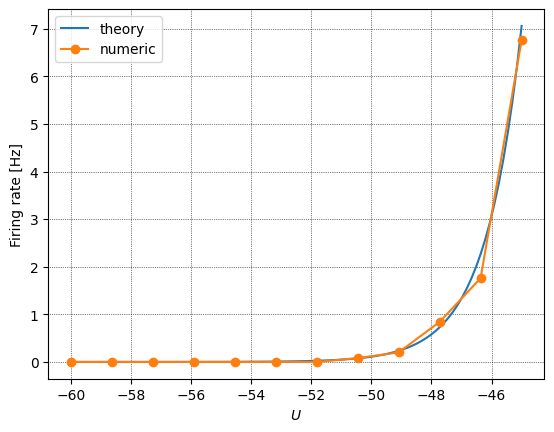

In [43]:
# theoretical Phi vs V_m
V_range_theory = np.linspace(-60., -45., 100)
Phi_of_V_theory = (1 / params['b']) * np.exp((V_range_theory - params['V_b']) / params['a'])

# numerical Phi vs V_m
V_range_numeric, spike_rate_numeric = measure_numerical_Phi_function(neuron_model_name=neuron_model_name,
                                                                     module_name=module_name,
                                                                     V_min=-60.,
                                                                     V_max=-45.,
                                                                     neuron_model_params={"reset_after_spike": False,
                                                                                          "a": params['a'],
                                                                                          "b": params['b'],
                                                                                          "V_b": params['V_b'],
                                                                                          "tau_m": 1E99})

fig, ax = plt.subplots()
ax.plot(V_range_theory, Phi_of_V_theory, label="theory")
ax.plot(V_range_numeric, spike_rate_numeric, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]");

## Explore responses to input

- Population of $N$ independent neurons
- Responses show random variation to identical input
- Two types of input
    - Constant current input
    - Poisson spike train input, where all neurons receive the same spike train

In [118]:
def evaluate_neuron(neuron_name, module_name, nneurons=1, neuron_parms=None, stimulus_type="constant", poisson_fr=0.0,
                    mu=500., sigma=0., t_sim=300., rseed=1000, dt=0.1, input_freq=0.0):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    nest.ResetKernel()
    nest.set_verbosity("M_ERROR")
    nest.print_time = False
    nest.Install(module_name)
    nest.SetKernelStatus({'rng_seed': rseed, 'resolution': dt})
    
    neuron = nest.Create(neuron_name, nneurons, params=neuron_parms)

    if stimulus_type == "poisson_spikes":
        # Create a Poisson generator device
        poisson = nest.Create("poisson_generator", params={"rate": poisson_fr})

        # Create a parrot neuron so all neurons get same input spike train
        parrot = nest.Create("parrot_neuron")

        # Connect the Poisson generator to the parrot neuron
        nest.Connect(poisson, parrot)

        # Connect the parrot neuron to each neuron
        nest.Connect(parrot, neuron)
    else:
        assert stimulus_type == "constant"
        nest.SetStatus(neuron, "I_e", mu)

    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m", "phi"],
                    "interval": nest.resolution})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)

    nest.Simulate(t_sim)
                    
    dre = spike_recorder.events
    ns = dre['senders']
    ts = dre["times"]

    return ts, ns, multimeter.events

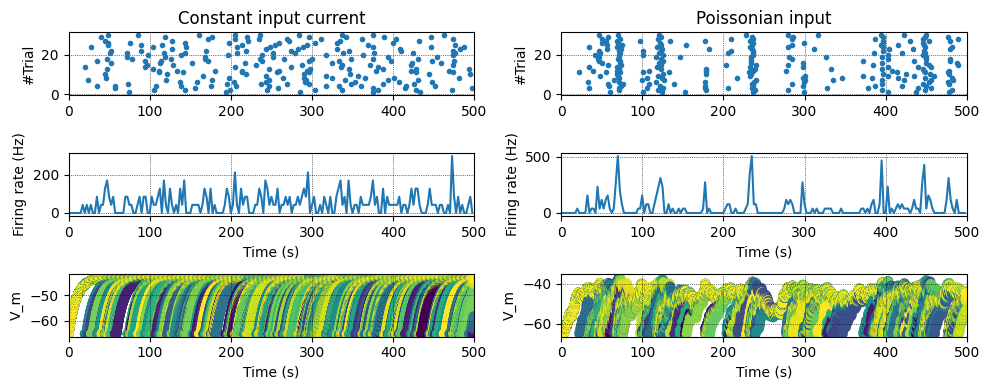

In [120]:
dt = 0.1
nneurons = 30
inp = None

ts_const, ns_const, dm_const = evaluate_neuron(neuron_model_name,
                                     module_name,
                                     nneurons=nneurons,
                                     neuron_parms=params,
                                     stimulus_type='constant',
                                     mu=550.,
                                     t_sim=500.0,
                                     dt=dt,
                                     poisson_fr=0.0)

ts_poiss, ns_poiss, dm_poiss = evaluate_neuron(neuron_model_name,
                                     module_name,
                                     nneurons=nneurons,
                                     neuron_parms=params,
                                     stimulus_type='poisson_spikes',
                                     t_sim=500.0,
                                     poisson_fr=2000.0)

# PSTH parameters
t_start = 0.0
t_stop = 500.0
t_step = 2.5
t_bins = np.arange(t_start, t_stop + t_step, t_step)

# Calculate the PSTH
psth_const, _ = np.histogram(ts_const, bins=t_bins)
psth_const = psth_const / len(ts_const) / (dt*1e-3)  # divide by number of trials and time bin size

psth_poiss, _ = np.histogram(ts_poiss, bins=t_bins)
psth_poiss = psth_poiss / len(ts_poiss) / (dt*1e-3)  # divide by number of trials and time bin size

plt.figure(figsize=(10,4))
# Raster plot
plt.subplot2grid((3,2),(0,0), rowspan=1)
plt.plot(ts_const, ns_const, '.')
plt.xlim(0, 500)
plt.ylabel('#Trial')
plt.title('Constant input current')

plt.subplot2grid((3,2),(0,1), rowspan=1)
plt.plot(ts_poiss, ns_poiss, '.')
plt.xlim(0, 500)
plt.ylabel('#Trial')
plt.title('Poissonian input')

# Plot the PSTH
plt.subplot2grid((3,2),(1,0), rowspan=1)
plt.plot(t_bins[:-1], psth_const)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(0, 500)

plt.subplot2grid((3,2),(1,1), rowspan=1)
plt.plot(t_bins[:-1], psth_poiss)
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (Hz)')
plt.xlim(0, 500)
plt.tight_layout()

# Plot membrane potential
plt.subplot2grid((3,2),(2,0), rowspan=1)
plt.scatter(dm_const["times"], dm_const["V_m"], c=dm_const["senders"], alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('V_m')
plt.xlim(0, 500)

plt.subplot2grid((3,2),(2,1), rowspan=1)
plt.scatter(dm_poiss["times"], dm_poiss["V_m"], c=dm_poiss["senders"], alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('V_m')
plt.xlim(0, 500)

plt.tight_layout();


## Acknowledgements

The authors would like to thank Renan Shimoura, Christophe Pouzat, Antonio Roque and Antonio Galves for their kind and helpful discussion and feedback.